<a href="https://colab.research.google.com/github/mohaddese136/webpage-spam-fuzzy-classifier/blob/main/dataFusion_sugeno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Read the train dataset into a dataframe
df = pd.read_csv('WEBSPAM-UK2007-SET1-labels.txt', sep=' ', header=None)

df.tail()

,0,1,2,3
4270,114351,nonspam,0.000000,"j6:N,j37:U"
4271,114420,nonspam,0.000000,"j8:N,j12:N"
4272,114443,nonspam,0.000000,"j25:N,j58:N"
4273,114454,nonspam,0.000000,"j28:N,j49:N"
4274,114505,undecided,0.500000,"j4:B,j7:U"


In [ ]:
#Calculate Judgers accuracy


membership_freq = {'0': 0,'S':0, 'N':0, 'U':0,'B':0.1 ,'S,N':0, 'S,U':0, 'N,U':0, 'S,N,U':0}
judge_acc = {}
for index, row in df.iterrows():

  if row[1]=='spam':
    membership_freq['S'] += 1
  elif row[1]=='nonspam':
    membership_freq['N'] += 1
  elif row[1]=='undecided':
    membership_freq['U'] += 1


  #process judges assesments
  tmp = row[3].split(",")
  for item in tmp:
    j_tmp = item.split(":")

    correct_count = 0
    if j_tmp[1] == 'N' and row[1] == 'nonspam':
      correct_count += 1
    elif j_tmp[1] == 'S' and row[1] == 'spam':
      correct_count += 1
    elif j_tmp[1] == 'U' and row[1] == 'undecided':
      correct_count += 1


    if j_tmp[0] not in judge_acc:
      # if it doesn't exist, add a new key-value pair to the dictionary
      #first value is correct assesments count
      #second value is total number of assesments for this judge
      judge_acc[j_tmp[0]] = [correct_count, 1]
    else:
      # if judge exists, update its value
      correct_tmp = judge_acc[j_tmp[0]][0]
      assesment_tmp = judge_acc[j_tmp[0]][1]
      judge_acc[j_tmp[0]] = [correct_tmp + correct_count, assesment_tmp+1]



#fix distribution flaw

max_assesment = max([value[1] for value in judge_acc.values()]) # sum the second values
for key, value in judge_acc.items():
  acc = (judge_acc[key][1] * (judge_acc[key][0]/judge_acc[key][1])) / max_assesment
  judge_acc[key].append(acc)


print("judges correct assesments, total assessment, precision")
judge_acc

judges correct assesments, total assessment, precision


{'j6': [220, 270, 0.6832298136645962],
 'j9': [221, 255, 0.6863354037267081],
 'j20': [238, 278, 0.7391304347826086],
 'j37': [145, 199, 0.4503105590062112],
 'j24': [256, 270, 0.7950310559006211],
 'j32': [181, 223, 0.562111801242236],
 'j10': [261, 274, 0.8105590062111802],
 'j36': [218, 262, 0.6770186335403726],
 'j58': [243, 283, 0.7546583850931677],
 'j59': [236, 258, 0.7329192546583851],
 'j26': [247, 266, 0.7670807453416149],
 'j34': [212, 247, 0.6583850931677019],
 'j38': [251, 263, 0.7795031055900621],
 'j31': [49, 53, 0.15217391304347827],
 'j52': [251, 263, 0.7795031055900621],
 'j22': [220, 257, 0.6832298136645962],
 'j13': [148, 158, 0.45962732919254656],
 'j28': [247, 272, 0.7670807453416149],
 'j48': [197, 264, 0.6118012422360248],
 'j44': [100, 134, 0.3105590062111801],
 'j49': [266, 297, 0.8260869565217391],
 'j16': [223, 264, 0.6925465838509317],
 'j39': [249, 261, 0.7732919254658385],
 'j35': [244, 264, 0.7577639751552795],
 'j11': [253, 279, 0.7857142857142857],
 'j

In [ ]:
#calculate membership

membership_freq['S,N'] = (membership_freq['S'] + membership_freq['N'])/len(df)
membership_freq['S,U'] = (membership_freq['S'] + membership_freq['U'])/len(df)
membership_freq['N,U'] = (membership_freq['N'] + membership_freq['U'])/len(df)
membership_freq['S,N,U'] = (membership_freq['S'] + membership_freq['N'] + membership_freq['U'])/len(df)
membership_freq['S'] = membership_freq['S'] /len(df)
membership_freq['N'] = membership_freq['N'] /len(df)
membership_freq['U'] = membership_freq['U'] /len(df)

print("membership function")
for key, value in membership_freq.items():
    print(key, ':',value)

membership function
0 : 0
S : 0.051929824561403506
N : 0.8832748538011695
U : 0.0647953216374269
B : 0.1
S,N : 0.9352046783625731
S,U : 0.11672514619883041
N,U : 0.9480701754385965
S,N,U : 1.0


In [ ]:
#Data Fusion
#use sugeno integral to calculate spamicity of each page


#Clone membership 3 final target for caption
targets = {key: value for key, value in membership_freq.items() if key in ['S', 'N', 'U']}

def find_nearset_assesment(d, num):
    """
    Given a dictionary `d` and a number `num`, subtract `num` from each value in the dictionary
    and return the key corresponding to the minimum resulting value.
    """
    min_result = float('inf')
    min_key = None
    for key, value in d.items():
        result = abs(value - num)
        if result < min_result:
            min_result = result
            min_key = key
    return min_key


def get_keys_with_same_first_value(d):
    result = {}
    for k, v in d.items():
        if v[0] in result:
            result[v[0]][0].append(k)
            if v[1] > result[v[0]][1]:
                result[v[0]][1] = v[1]
        else:
            result[v[0]] = [[k], v[1]]
    return {k: v for k, v in result.items()}



final_result = []
final_caption = []
for index, row in df.iterrows():
  tmp = row[3].split(",")
  judges_per_file = {}
  for item in tmp:
    j_tmp = item.split(":")
    judges_per_file[j_tmp[0]] = [j_tmp[1],judge_acc[j_tmp[0]][2]]

  # sorted_judges_per_file = dict(sorted(judges_per_file.items(), key=lambda x: x[1][1]))


  #group judges by assesment
  grouped_assesments = get_keys_with_same_first_value(judges_per_file)
  sorted_assesments = dict(sorted(grouped_assesments.items(), key=lambda x: x[1][1]))

  mins = []
  for key, value in sorted_assesments.items():
    min_value = min(membership_freq[key],sorted_assesments[key][1])
    mins.append(min_value)

  final_result.append(max(mins))
  final_caption.append(find_nearset_assesment(targets,max(mins)))

df['predicted'] = final_result
df['predicted_caption'] = final_caption

df

,0,1,2,3,predicted,predicted_caption
0,4,nonspam,0.000000,"j6:N,j9:N,j20:N,j37:N",0.739130,N
1,5,nonspam,0.000000,"j24:N,j32:N",0.795031,N
2,8,nonspam,0.000000,"j10:N,j36:N",0.810559,N
3,61,nonspam,0.000000,"j58:N,j59:N",0.754658,N
4,62,nonspam,0.000000,"j6:N,j26:N",0.767081,N
...,...,...,...,...,...,...
4270,114351,nonspam,0.000000,"j6:N,j37:U",0.683230,N
4271,114420,nonspam,0.000000,"j8:N,j12:N",0.745342,N
4272,114443,nonspam,0.000000,"j25:N,j58:N",0.788820,N
4273,114454,nonspam,0.000000,"j28:N,j49:N",0.826087,N


**TESTING MODEL**

In [ ]:

test_set = pd.read_csv('WEBSPAM-UK2007-SET2-labels.txt', sep=' ', header=None)

test_set.tail()

,0,1,2,3
2199,114401,nonspam,0.000000,"j40:N,j48:N"
2200,114442,nonspam,0.000000,"j48:N,j49:N"
2201,114469,spam,1.000000,"j7:U,j36:S"
2202,114487,nonspam,0.000000,"j13:N,j28:N"
2203,114507,nonspam,0.000000,"j36:N,j44:N"


In [ ]:

final_result = []
final_caption = []
acc =[]

for index, row in test_set.iterrows():
  tmp = row[3].split(",")
  judges_per_file = {}
  for item in tmp:
    j_tmp = item.split(":")
    #judger key might not exist in training
    precision= 0.1
    if j_tmp[0] in judge_acc:
      precision = judge_acc[j_tmp[0]][2]

    judges_per_file[j_tmp[0]] = [j_tmp[1],precision]


  #group judges by assesment
  grouped_assesments = get_keys_with_same_first_value(judges_per_file)
  sorted_assesments = dict(sorted(grouped_assesments.items(), key=lambda x: x[1][1]))

  mins = []
  for key, value in sorted_assesments.items():
    min_value = min(membership_freq[key],sorted_assesments[key][1])
    mins.append(min_value)

  final_result.append(max(mins))
  final_caption.append(find_nearset_assesment(targets,max(mins)))
  if row[1] == 'nonspam' and final_caption[len(final_caption)-1] == 'N':
    acc.append(1)
  elif row[1] == 'spam' and final_caption[len(final_caption)-1] == 'S':
    acc.append(1)
  elif row[1] == 'undecided' and final_caption[len(final_caption)-1] == 'U':
    acc.append(1)
  else:
    acc.append(0)

test_set['predicted'] = final_result
test_set['predicted_caption'] = final_caption
test_set['acc'] = acc

test_set

,0,1,2,3,predicted,predicted_caption,acc
0,182,nonspam,0.000000,"j7:N,j59:N",0.732919,N,1
1,262,nonspam,0.000000,"j40:N,j35:N",0.757764,N,1
2,327,nonspam,0.000000,"j6:U,j20:N",0.739130,N,1
3,377,nonspam,0.000000,"j9:N,j11:N,j12:N,j37:N,j52:N,j39:N",0.785714,N,1
4,418,nonspam,0.000000,"j40:N,j48:N",0.683230,N,1
...,...,...,...,...,...,...,...
2199,114401,nonspam,0.000000,"j40:N,j48:N",0.683230,N,1
2200,114442,nonspam,0.000000,"j48:N,j49:N",0.826087,N,1
2201,114469,spam,1.000000,"j7:U,j36:S",0.064795,U,0
2202,114487,nonspam,0.000000,"j13:N,j28:N",0.767081,N,1


In [ ]:
#calculate accuracy in test set
total_sum = test_set['acc'].sum()
sugeno_acc = total_sum/len(test_set)
print('Model Accuracy is: ',sugeno_acc )


Model Accuracy is:  0.911524500907441


**Second part (predict spamicity)**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Read dataset from file
data = pd.read_csv('uk-2007-05.link_based_features.csv')

data
# # Split features and labels
# X = data.drop('is_spam', axis=1)
# y = data['is_spam']

# # Create and fit random forest classifier
# rfc = RandomForestClassifier()
# rfc.fit(X, y)

# # Predict probabilities of each page being spam
# probabilities = rfc.predict_proba(X)

# # Print results
# for i, p in enumerate(probabilities):
#     print(f"Page {i+1} has a {p[1]*100:.2f}% chance of being spam")

,#hostid,hostname,eq_hp_mp,assortativity_hp,assortativity_mp,avgin_of_out_hp,avgin_of_out_mp,avgout_of_in_hp,avgout_of_in_mp,indegree_hp,...,truncatedpagerank_1_hp,truncatedpagerank_1_mp,truncatedpagerank_2_hp,truncatedpagerank_2_mp,truncatedpagerank_3_hp,truncatedpagerank_3_mp,truncatedpagerank_4_hp,truncatedpagerank_4_mp,trustrank_hp,trustrank_mp
0,0,0800.loan-line.co.uk,0,2.419355,2.516854,56.000000,0.000000,17.745762,16.000000,59,...,8.691738e-09,1.772127e-08,4.953765e-09,1.146529e-08,3.482127e-09,6.982786e-09,2.767588e-09,5.175960e-09,3.196748e-09,4.911842e-09
1,1,1-2clacton.boys-brigade.org.uk,1,0.059211,0.059211,0.500000,0.500000,163.166672,163.166672,6,...,2.621466e-08,2.621466e-08,2.797404e-08,2.797404e-08,2.957032e-08,2.957032e-08,3.120353e-08,3.120353e-08,2.491353e-08,2.491353e-08
2,2,1-hydroponics.co.uk,0,0.238186,6.292779,280.615387,372.148163,73.516129,26.582609,31,...,1.890747e-08,3.531105e-08,1.393413e-08,2.751493e-08,1.089009e-08,2.180649e-08,8.645348e-09,1.772911e-08,4.023863e-09,1.163742e-08
3,3,102belfast.boys-brigade.org.uk,0,0.313726,1.374449,8.900000,6.833333,80.461540,9.000000,13,...,1.398497e-08,1.644882e-08,1.458067e-08,1.674230e-08,1.517079e-08,1.695986e-08,1.565379e-08,1.728460e-08,3.259370e-09,3.978823e-09
4,4,109belfast.boys-brigade.org.uk,1,0.001186,0.001186,20093.000000,20093.000000,239.000000,239.000000,4,...,8.475692e-10,8.475692e-10,8.820278e-10,8.820278e-10,8.986675e-10,8.986675e-10,9.174294e-10,9.174294e-10,5.938985e-10,5.938985e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6522,6522,skiers-lodge.co.uk,1,1.000000,1.000000,8.000000,8.000000,8.000000,8.000000,8,...,1.263596e-08,1.263596e-08,1.290186e-08,1.290186e-08,1.314935e-08,1.314935e-08,1.338341e-08,1.338341e-08,2.939483e-09,2.939483e-09
6523,6523,skillsbank.cf.ac.uk,1,0.049453,0.049453,9787.904297,9787.904297,32.166668,32.166668,84,...,3.459571e-08,3.459571e-08,3.694786e-08,3.694786e-08,3.901829e-08,3.901829e-08,4.081762e-08,4.081762e-08,2.430054e-08,2.430054e-08
6524,6524,skinners-sheds.co.uk,1,1.276411,1.276411,31.857143,31.857143,19.794117,19.794117,34,...,1.758878e-08,1.758878e-08,1.691234e-08,1.691234e-08,1.624004e-08,1.624004e-08,1.563299e-08,1.563299e-08,4.301485e-09,4.301485e-09
6525,6525,skinsvilles.mysite.wanadoo-members.co.uk,0,0.369942,1.022727,5.000000,5.000000,38.000000,4.200000,3,...,5.994376e-10,1.576149e-08,4.886255e-10,1.614697e-08,4.234567e-10,1.649181e-08,3.801962e-10,1.681012e-08,5.458755e-10,3.556668e-09


In [ ]:
pip install sklearn-genetic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.7 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from genetic_selection import GeneticSelectionCV

feature_data = pd.read_csv('uk-2007-05.link_based_features.csv', index_col=0)
content_data = pd.read_csv('uk-2007-05.content_based_features.csv', index_col=0)
content_data.drop('hostname',axis=1, inplace=True)
feature_data.drop('hostname',axis=1, inplace=True)

full_data = pd.merge(feature_data, content_data, left_index=True, right_index=True)



#preprocess dataset
data = full_data.loc[full_data.index.isin(df.iloc[:, 0])]
data['is_spam'] = data.index.map(lambda x: df.loc[df.iloc[:,0] == x, 'predicted_caption'].iloc[0])




#embed feaures
le = LabelEncoder()
data['pagerank_hp'] = le.fit_transform(data['pagerank_hp'])
data['pagerank_mp'] = le.fit_transform(data['pagerank_mp'])
data['prsigma_mp'] = le.fit_transform(data['prsigma_mp'])
data['truncatedpagerank_1_hp'] = le.fit_transform(data['truncatedpagerank_1_hp'])
data['truncatedpagerank_1_mp'] = le.fit_transform(data['truncatedpagerank_1_mp'])
data['truncatedpagerank_2_hp'] = le.fit_transform(data['truncatedpagerank_2_hp'])
data['truncatedpagerank_2_mp'] = le.fit_transform(data['truncatedpagerank_2_mp'])
data['truncatedpagerank_3_hp'] = le.fit_transform(data['truncatedpagerank_3_hp'])
data['truncatedpagerank_3_mp'] = le.fit_transform(data['truncatedpagerank_3_mp'])
data['truncatedpagerank_4_hp'] = le.fit_transform(data['truncatedpagerank_4_hp'])
data['truncatedpagerank_4_mp'] = le.fit_transform(data['truncatedpagerank_4_mp'])
data['trustrank_hp'] = le.fit_transform(data['trustrank_hp'])
data['trustrank_mp'] = le.fit_transform(data['trustrank_mp'])



# Split features and labels
X = data.drop('is_spam', axis=1)
y = data['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)


ga = GeneticSelectionCV(RandomForestClassifier(),
                        cv=3,
                        verbose=1,
                        scoring="accuracy",
                        n_population=10,
                        crossover_proba=0.5,
                        mutation_proba=0.2,
                        n_generations=35,
                        crossover_independent_proba=0.5,
                        mutation_independent_proba=0.05,
                        tournament_size=3,
                        caching=True,
                        n_jobs=-1)

estimator = []
estimator.append(('GP', ga ))
estimator.append(('RF', RandomForestClassifier(n_estimators = 100)))

# combine genetic programming and random forest
vot_hard = VotingClassifier(estimators = estimator, voting ='soft')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_test)


spamicity = vot_hard.predict_proba(X)

data['spamicity'] = spamicity[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))

data

<ipython-input-147-62fd82b02a06>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_spam'] = data.index.map(lambda x: df.loc[df.iloc[:,0] == x, 'predicted_caption'].iloc[0])
<ipython-input-147-62fd82b02a06>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pagerank_hp'] = le.fit_transform(data['pagerank_hp'])
<ipython-input-147-62fd82b02a06>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Selecting features with genetic algorithm.
gen	nevals	avg                               	std                               	min                            	max                                  
0  	10    	[  0.826845  51.7        0.002782]	[  0.002616  38.592875   0.001811]	[ 0.821723  6.        0.001071]	[   0.831129  121.          0.007338]
1  	5     	[  0.828935  71.1        0.002932]	[  0.001304  19.684766   0.001606]	[  0.827298  39.         0.00078 ]	[   0.831129  100.          0.004747]
2  	8     	[  0.829109  73.         0.002132]	[ 0.001669  8.5557    0.000888]   	[  0.825557  67.         0.00124 ]	[  0.831129  93.         0.004622]   
3  	0     	[  0.830502  71.2        0.001672]	[ 0.000957  6.4       0.000295]   	[  0.829039  68.         0.00124 ]	[  0.831129  84.         0.002377]   
4  	4     	[  0.830641  68.         0.001768]	[ 0.001198  0.        0.000282]   	[  0.828344  68.         0.001241]	[  0.832173  68.         0.002377]   
5  	8     	[  0.829702  68.9        0.0

/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  warnings.warn(


Accuracy: 0.8505280259951259


<ipython-input-147-62fd82b02a06>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['spamicity'] = spamicity[:,1]


,eq_hp_mp,assortativity_hp,assortativity_mp,avgin_of_out_hp,avgin_of_out_mp,avgout_of_in_hp,avgout_of_in_mp,indegree_hp,indegree_mp,neighbors_2_hp,...,STD_89,STD_90,STD_91,STD_92,STD_93,STD_94,STD_95,STD_96,is_spam,spamicity
#hostid,,,,,,,,,,,,,,,,,,,,,
4,1,0.001186,0.001186,20093.000000,20093.000000,239.000000,239.000000,4,4,35,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,N,0.015
5,1,0.885731,0.885731,16.909090,16.909090,42.393940,42.393940,33,33,97,...,0.002882,0.004603,0.000223,0.001414,0.001416,0.000567,0.730257,0.635154,N,0.000
8,1,0.074253,0.074253,1.500000,1.500000,61.777779,61.777779,18,18,4340,...,0.003927,0.005491,0.009611,0.002665,0.002668,0.003952,1.295359,1.075073,N,0.005
61,0,0.033302,1.448276,13.000000,10.285714,196.399994,7.076923,5,13,74,...,0.007376,0.008834,0.000221,0.000213,0.000120,0.000122,0.835484,0.610877,N,0.010
62,0,0.807415,1.469636,1.000000,18.181818,53.680851,11.571428,47,21,244,...,0.002855,0.002916,0.003115,0.004348,0.002474,0.000999,0.796034,0.781804,N,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114280,1,3.275590,3.275590,0.833333,0.833333,5.760000,5.760000,25,25,40,...,0.001389,0.001500,0.000252,0.000149,0.000131,0.000082,0.338401,0.390096,N,0.005
114340,0,0.299887,2.254658,53.000000,32.916668,73.909088,14.943397,22,53,33,...,0.000729,0.001354,0.080405,0.067426,0.035390,0.024618,1.384490,1.099639,N,0.010
114351,0,9.036162,8.700398,1.000000,325.238098,51.138954,31.316372,842,452,9948,...,0.006652,0.012117,0.009769,0.010618,0.004948,0.002712,3.589906,3.172707,N,0.005


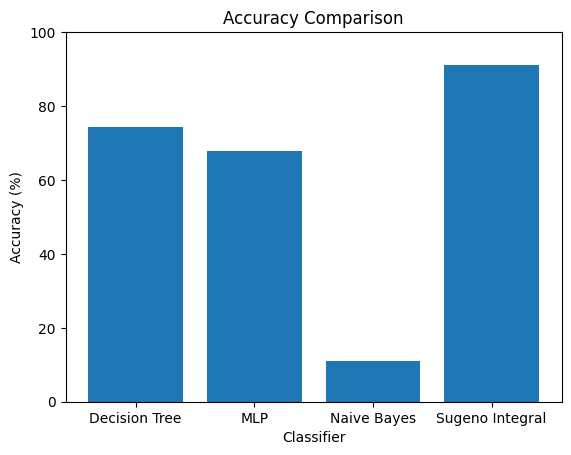

In [ ]:

#Compare Sugeno to Other Models
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



data.drop('spamicity',axis=1, inplace=True)

X = data.drop('is_spam', axis=1)
y = data['is_spam']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create the classifiers
clf_dt = DecisionTreeClassifier()
clf_mlp = MLPClassifier()
clf_nb = GaussianNB()

# Train the classifiers
clf_dt.fit(X_train, y_train)
clf_mlp.fit(X_train, y_train)
clf_nb.fit(X_train, y_train)

# Predict the test data and calculate the accuracy
y_pred_dt = clf_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt) * 100

y_pred_mlp = clf_mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp) * 100

y_pred_nb = clf_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb) * 100

# Plot the accuracy results in a bar chart
labels = ['Decision Tree', 'MLP', 'Naive Bayes', 'Sugeno Integral']
accuracies = [accuracy_dt, accuracy_mlp, accuracy_nb, sugeno_acc*100]
plt.bar(labels, accuracies)
plt.title('Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.show()


